### Self-Driving Cab Use Case

There are 4 locations and our job is to pick up the passenger at one location and drop him off at another. <br>

**Rewards or Penality**:
- We will receive +20 points for a successful drop-off 
- Lose 1 point for every time-step it takes. 
- There is also a 10 point penalty for illegal pick-up and drop-off actions.

In [1]:
# Importing the required libraries
import gym
import numpy as np
import random
from IPython.display import clear_output

In [2]:
# Loading the self driving cab environment from gym library
env = gym.make("Taxi-v2")

In [3]:
# Total Number of states
env.observation_space

Discrete(500)

### Implementing Q-learning

In [4]:
# Four pick up and drop location of a passenger: R, G, Y, B

In [5]:
# Initialize the Q-table with 500Ã—6 (Numbe of States * Number of actions) matrix of zeros:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [6]:
q_table.shape

(500, 6)

- **env.reset**: Resets the environment and returns a random initial state.
- **env.step(action)**: Step the environment by one timestep. Returns
    - **observation**: Observations of the environment
    - **reward**: If your action was beneficial or not
    - **done**: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
    - **info**: Additional info such as performance and latency for debugging purposes
- **env.render**: Renders one frame of the environment (helpful in visualizing the environment)

**Q-values updation equation**:

    Q(state,action) = (1âˆ’Î±)Q(state,action) + Î± (reward + Î³ * max_aQ(next state,all actions))

- **Î± (alpha) is the learning rate (0<Î±â‰¤1)**: Extent to which our Q-values are being updated in every iteration.

- **Î³ (gamma) is the discount factor (0â‰¤Î³â‰¤1)**: Determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

### Training simple reinforcement learning - Q Learning

#### Training the Agent and updating the Q_table

In [7]:
# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Capturing the epochs and penalities for each episode
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    # Initializing the epochs, penalities, rewads to zero
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    # For every episode or ride getting the action, calculating the rewards,
    # penalities and updating the Q table
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        # Capturing the new state, awards and episode completion flag based on t he action
        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # Caluculating the new Q value and updating the Q table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        
        # Increasing the penality for worng drop location
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    # Appending the list with time steps and penalities for each episode
    all_epochs.append(epochs)
    all_penalties.append(penalties)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.



In [8]:
import pandas as pd
Q_RL = {'episodes':range(1, 100001),'epochs':all_epochs,"rewards" : all_penalties}
Q_RL_DF = pd.DataFrame(Q_RL)

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(1, 100001), all_epochs, linewidth=2.0)
plt.xlabel("Episodes",fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel("Time Steps",fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Episodes Vs Time Steps")

Text(0.5, 1.0, 'Episodes Vs Time Steps')

Text(0.5, 1.0, 'Episodes Vs Penality')

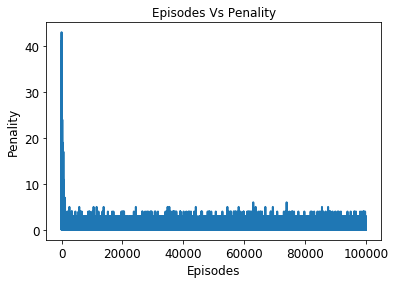

In [10]:
import matplotlib.pyplot as plt
#plt.plot(num_episodes, all_epochs_new)
plt.plot(range(1, 100001), all_penalties, linewidth=2.0)
plt.xlabel("Episodes",fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel("Penality",fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Episodes Vs Penality")

In [11]:
np.mean(all_epochs)

14.8242

In [12]:
sum(all_epochs)/100000

14.8242

In [13]:
q_table[328]

array([-0.79057098,  1.62261467, -0.90513311,  0.1884846 , -7.96927147,
       -8.20606421])

#### Evaluating agent's performance after Q-learning

In [14]:
total_epochs, total_penalties = 0, 0
episodes = 100

# For different episodes capturing the number of epochs/time steps, penality and reward points
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode with simple Q learning: {total_epochs / episodes}")
print(f"Average penalties per episode with simple Q learning: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode with simple Q learning: 12.46
Average penalties per episode with simple Q learning: 0.0


### Training the reinforcement Q learning model with NN

In [15]:
observation_space = env.observation_space.n
action_space = env.action_space.n

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [17]:
# Tuning on the discount rate hyper parameter

In [18]:
discRateFac = [0.1,0.5,0.95]
decay_factor = 0.999
num_episodes = 2500

import datetime
ts = datetime.datetime.now() 

# Creating . empty list
all_epochs_hyperparm = [[] for _ in range(len(discRateFac))]
all_rewards_hyperparm = [[] for _ in range(len(discRateFac))]
tmp = 0


# For differnt discount factor parameter capturing the time steps and rewards for each episode
for dicfac in discRateFac:
    epochs_hyp = []
    rewards_list = []
    eps = 0.5
    
    # Defining the NN model with 2 hidden layers
    model1 = Sequential()
    model1.add(Dense(100,input_shape=(observation_space,), activation='relu'))
    model1.add(Dense(50, activation='relu'))
    model1.add(Dense(action_space, activation='linear'))
    model1.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    # For each episode capturing the rewards, time steps and updating the model
    for i in range(num_episodes):
        # Random initialization of the state
        hyp_state = env.reset()
        eps *= decay_factor
        
        if i % 100 == 0:
            print("Episode {} of {}".format(i + 1, num_episodes))
        
        done = False
        reward_sum_hyp = 0
        epochs_new = 0
        
        # Captuing the time steps for each episode
        while not done:
            # Exploration - Randomply selecting the action
            if np.random.random() < eps:
                hyp_action = env.action_space.sample()
            else:
                # Exploitation - Selecting the action based using model predictions
                hyp_action = np.argmax(model1.predict(np.identity(500)[hyp_state:hyp_state + 1]))
            
            # Capturing the new state, awards and episode completion flag based on t he action
            new_state, reward_hyp, done, _ = env.step(hyp_action)
            # Calucating the Q values based on the next action and adding the rewards
            target = reward_hyp + dicfac * np.max(model1.predict(np.identity(500)[new_state:new_state + 1]))
            # Getting the Q values for the current state
            target_vec = model1.predict(np.identity(500)[hyp_state:hyp_state + 1])[0]
            # Updating the Q value of the current state
            target_vec[hyp_action] = target
            # Fitting or updating the NN model with the new Q values 
            model1.fit(np.identity(500)[hyp_state:hyp_state + 1], target_vec.reshape(-1, 6), epochs=1, verbose=0)
            # Updating the current state with new state
            hyp_state = new_state
            # Capturing the total rewards for each episode
            reward_sum_hyp += reward_hyp
            # Capturing the total time steps
            epochs_new += 1
        
        rewards_list.append(reward_sum_hyp)
        epochs_hyp.append(epochs_new)
        
    # For each hyper parameter at each episode level capturing the time steps and rewards
    all_epochs_hyperparm[tmp] = epochs_hyp
    all_rewards_hyperparm[tmp] = rewards_list
    tmp += 1

    
ts1 = datetime.datetime.now() 

Instructions for updating:
Colocations handled automatically by placer.
Episode 1 of 2500
Instructions for updating:
Use tf.cast instead.
Episode 101 of 2500
Episode 201 of 2500
Episode 301 of 2500
Episode 401 of 2500
Episode 501 of 2500
Episode 601 of 2500
Episode 701 of 2500
Episode 801 of 2500
Episode 901 of 2500
Episode 1001 of 2500
Episode 1101 of 2500
Episode 1201 of 2500
Episode 1301 of 2500
Episode 1401 of 2500
Episode 1501 of 2500
Episode 1601 of 2500
Episode 1701 of 2500
Episode 1801 of 2500
Episode 1901 of 2500
Episode 2001 of 2500
Episode 2101 of 2500
Episode 2201 of 2500
Episode 2301 of 2500
Episode 2401 of 2500
Episode 1 of 2500
Episode 101 of 2500
Episode 201 of 2500
Episode 301 of 2500
Episode 401 of 2500
Episode 501 of 2500
Episode 601 of 2500
Episode 701 of 2500
Episode 801 of 2500
Episode 901 of 2500
Episode 1001 of 2500
Episode 1101 of 2500
Episode 1201 of 2500
Episode 1301 of 2500
Episode 1401 of 2500
Episode 1501 of 2500
Episode 1601 of 2500
Episode 1701 of 2500
E

In [19]:
print(f"Average timesteps per episode with discount rate **0.1**: {np.mean(all_epochs_hyperparm[0])}")
print(f"Average timesteps per episode with discount rate **0.5**: {np.mean(all_epochs_hyperparm[1])}")
print(f"Average timesteps per episode with discount rate **0.95**: {np.mean(all_epochs_hyperparm[2])}")

Average timesteps per episode with discount rate **0.1**: 198.994
Average timesteps per episode with discount rate **0.5**: 183.5136
Average timesteps per episode with discount rate **0.95**: 51.416


In [20]:
print(f"Average reward per episode with discount rate **0.1**: {np.mean(all_rewards_hyperparm[0])}")
print(f"Average reward per episode with discount rate **0.5**: {np.mean(all_rewards_hyperparm[1])}")
print(f"Average reward per episode with discount rate **0.95**: {np.mean(all_rewards_hyperparm[2])}")

Average reward per episode with discount rate **0.1**: -304.4332
Average reward per episode with discount rate **0.5**: -278.2068
Average reward per episode with discount rate **0.95**: -79.6628


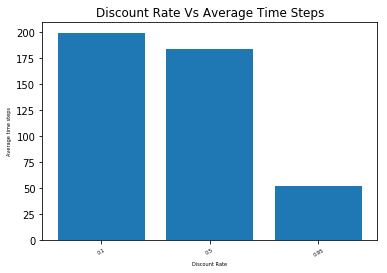

In [21]:
index = np.arange(len(discRateFac))
epocs_hype = [np.mean(all_epochs_hyperparm[0]),np.mean(all_epochs_hyperparm[1]),np.mean(all_epochs_hyperparm[2])]
plt.bar(index,epocs_hype)
plt.xlabel('Discount Rate', fontsize=5)
plt.ylabel('Average time steps', fontsize=5)
plt.xticks(index, discRateFac, fontsize=5, rotation=30)
plt.title('Discount Rate Vs Average Time Steps')
plt.show()

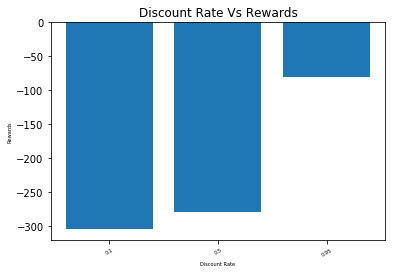

In [22]:
index = np.arange(len(discRateFac))
rewards_hype = [np.mean(all_rewards_hyperparm[0]),np.mean(all_rewards_hyperparm[1]),np.mean(all_rewards_hyperparm[2])]
plt.bar(index,rewards_hype)
plt.xlabel('Discount Rate', fontsize=5)
plt.ylabel('Rewards', fontsize=5)
plt.xticks(index, discRateFac, fontsize=5, rotation=30)
plt.title('Discount Rate Vs Rewards')
plt.show()

#### Building the final model based on the hyper paramer

In [23]:
# Defining the NN model with 2 hidden layers
model = Sequential()
model.add(Dense(100,input_shape=(observation_space,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 306       
Total params: 55,456
Trainable params: 55,456
Non-trainable params: 0
_________________________________________________________________


In [25]:
# now execute the q learning
finalDiscRate = 0.95
eps = 0.5
decay_factor = 0.999
num_episodes = 2500
final_rewards = []
all_epochs_new = []

import datetime
ts = datetime.datetime.now() 

# For each episode capturing the rewards, time steps and updating the model
for i in range(num_episodes):
    # Random initialization of the state
    final_state = env.reset()
    eps *= decay_factor
    
    if i % 100 == 0:
        print("Episode {} of {}".format(i + 1, num_episodes))
    
    done = False
    reward_sum_fin = 0
    epochs_new_fin = 0
    
    # Captuing the time steps for each episode
    while not done:
        # Exploration - Randomply selecting the action
        if np.random.random() < eps:
            action_fin = env.action_space.sample()
        else:
            # Exploitation - Selecting the action based using model predictions
            action_fin = np.argmax(model.predict(np.identity(500)[final_state:final_state + 1]))
        
        # Capturing the new state, awards and episode completion flag based on t he action
        new_state_fin, reward_fin, done, _ = env.step(action_fin)
        # Calucating the Q values based on the next action and adding the rewards
        target_fin = reward_fin + finalDiscRate * np.max(model.predict(np.identity(500)[new_state_fin:new_state_fin + 1]))
        # Getting the Q values for the current state
        target_vec_fin = model.predict(np.identity(500)[final_state:final_state + 1])[0]
        # Updating the Q value of the current state
        target_vec_fin[action_fin] = target_fin
        # Fitting or updating the NN model with the new Q values
        model.fit(np.identity(500)[final_state:final_state + 1], target_vec_fin.reshape(-1, 6), epochs=1, verbose=0)
        # Updating the current state with new state
        final_state = new_state_fin
        # Capturing the total rewards for each episode
        reward_sum_fin += reward_fin
        # Capturing the total time steps
        epochs_new_fin += 1
    
    # For each episode capturing the time steps and rewards
    final_rewards.append(reward_sum_fin)
    all_epochs_new.append(epochs_new_fin)
    
ts1 = datetime.datetime.now() 

Episode 1 of 2500
Episode 101 of 2500
Episode 201 of 2500
Episode 301 of 2500
Episode 401 of 2500
Episode 501 of 2500
Episode 601 of 2500
Episode 701 of 2500
Episode 801 of 2500
Episode 901 of 2500
Episode 1001 of 2500
Episode 1101 of 2500
Episode 1201 of 2500
Episode 1301 of 2500
Episode 1401 of 2500
Episode 1501 of 2500
Episode 1601 of 2500
Episode 1701 of 2500
Episode 1801 of 2500
Episode 1901 of 2500
Episode 2001 of 2500
Episode 2101 of 2500
Episode 2201 of 2500
Episode 2301 of 2500
Episode 2401 of 2500


In [26]:
np.mean(all_epochs_new)

68.9864

In [36]:
np.mean(all_epochs_new[2400:2500])

13.52

### Evaluating the agent's performance with Deep Q-learning

In [27]:
total_epochs_test, total_penalties_test = [], 0
episodes_test = 100

for _ in range(episodes_test):
    state = env.reset()
    epochs_test, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(model.predict(np.identity(500)[state:state + 1])) #np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs_test += 1

    total_penalties_test += penalties
    total_epochs_test.append(epochs_test)

print(f"Results after {episodes_test} episodes:")
print(f"Average timesteps per episode using DL: {np.mean(total_epochs_test)}")
print(f"Average penalties per episode using DL: {total_penalties_test / episodes_test}")

Results after 100 episodes:
Average timesteps per episode using DL: 24.04
Average penalties per episode using DL: 0.0


In [28]:
total_epochs

1246

In [29]:
import pandas as pd
d = {'episodes':list(range(num_episodes)),'epochs':all_epochs_new,"rewards" : final_rewards}
train_epochs = pd.DataFrame(d)

Text(0.5, 1.0, 'Time Steps Vs Episodes')

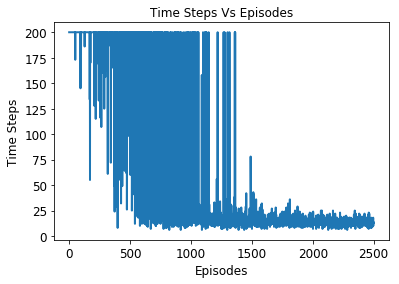

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(num_episodes), all_epochs_new, linewidth=2.0)
plt.xlabel("Episodes",fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel("Time Steps",fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Time Steps Vs Episodes")

Text(0.5, 1.0, 'Rewards Vs Episodes')

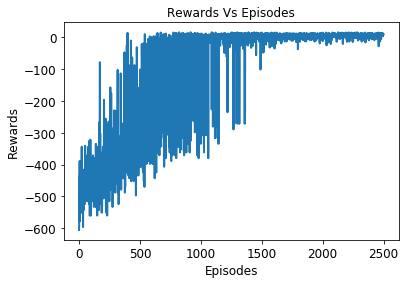

In [31]:
plt.plot(range(num_episodes), final_rewards, linewidth=2.0)
plt.xlabel("Episodes",fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel("Rewards",fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Rewards Vs Episodes")

#### Final Simple Reinforcment Learning Vs Reinforcment learning with NN Train and Test results

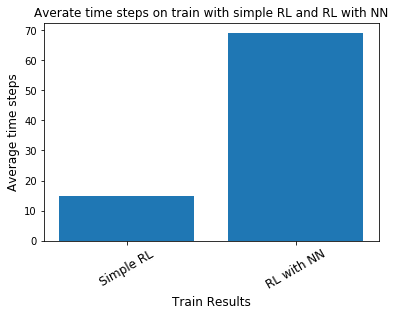

In [38]:
index = np.arange(2)
plt.bar(index,[np.mean(all_epochs),np.mean(all_epochs_new)])
plt.xlabel('Train Results', fontsize=12)
plt.ylabel('Average time steps', fontsize=12)
plt.xticks(index, ["Simple RL","RL with NN"], fontsize=12, rotation=30)
plt.title('Averate time steps on train with simple RL and RL with NN')
plt.show()

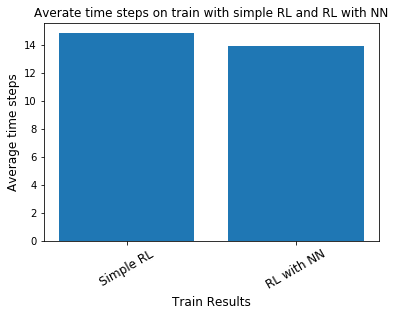

In [39]:
index = np.arange(2)
plt.bar(index,[np.mean(all_epochs),np.mean(all_epochs_new[2000:2500])])
plt.xlabel('Train Results', fontsize=12)
plt.ylabel('Average time steps', fontsize=12)
plt.xticks(index, ["Simple RL","RL with NN"], fontsize=12, rotation=30)
plt.title('Averate time steps on train with simple RL and RL with NN')
plt.show()

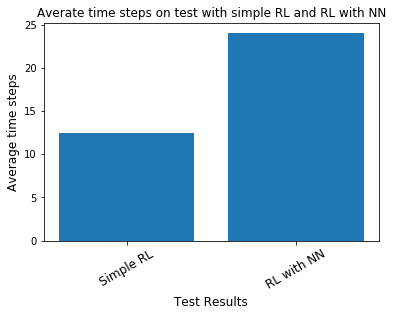

In [33]:
index = np.arange(2)
plt.bar(index,[total_epochs / episodes,np.mean(total_epochs_test)])
plt.xlabel('Test Results', fontsize=12)
plt.ylabel('Average time steps', fontsize=12)
plt.xticks(index, ["Simple RL","RL with NN"], fontsize=12, rotation=30)
plt.title('Averate time steps on test with simple RL and RL with NN')
plt.show()

Reference:
    - https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
    - https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/
    - https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/